In [1]:
import os
from tqdm import tqdm
import numpy as np
from PIL import Image
from torchvision import transforms

c:\Users\Tmenova\personal\tum\thesis\thesis-codebase\thesis_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/liver2_mini/images"
PROCESSED_IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/liver2_mini/preprocessed"

if not os.path.exists(PROCESSED_IMAGE_FOLDER):
    os.makedirs(PROCESSED_IMAGE_FOLDER)

In [3]:
images = sorted(os.listdir(IMAGE_FOLDER))

## KORNIA DATA PROCESSING

In [4]:
%%capture
!pip install kornia
!pip install kornia-rs

In [5]:
import kornia as K
import torch
import torchvision
from matplotlib import pyplot as plt

c:\Users\Tmenova\personal\tum\thesis\thesis-codebase\thesis_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


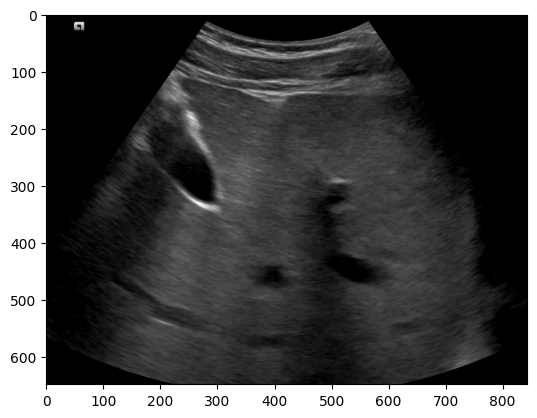

In [6]:
im0=images[0]
im_file = os.path.join(IMAGE_FOLDER, im0)
im = Image.open(im_file).convert('RGB')
plt.imshow(im)

In [7]:
# ref: https://kornia.github.io/tutorials/nbs/filtering_operators.html
x_rgb: torch.Tensor = K.io.load_image(im_file, K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
x_gray = K.color.rgb_to_grayscale(x_rgb)

In [8]:
def imshow(input: torch.Tensor):
    if input.shape != x_rgb.shape:
        input = K.geometry.resize(input, size=(x_rgb.shape[-2:]))
    out = torch.cat([x_rgb, input], dim=-1)
    out = torchvision.utils.make_grid(out, nrow=2, padding=5)
    out_np = K.utils.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis("off")
    plt.show()

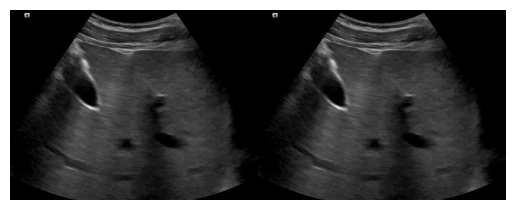

In [9]:
imshow(x_rgb)

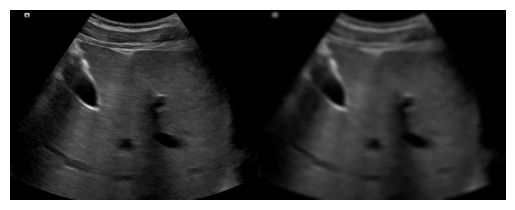

In [72]:
# Gaussian blur
x_blur_gs: torch.Tensor = K.filters.gaussian_blur2d(x_rgb, (21, 21), (5.0, 5.0))
imshow(x_blur_gs)

In [11]:
# guided blur 
# ref https://kornia.readthedocs.io/en/latest/filters.html

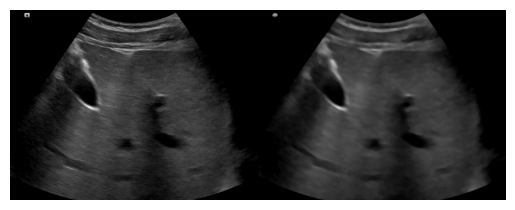

In [108]:
x_blur: torch.Tensor = K.filters.median_blur(x_rgb, (11, 11))
imshow(x_blur)

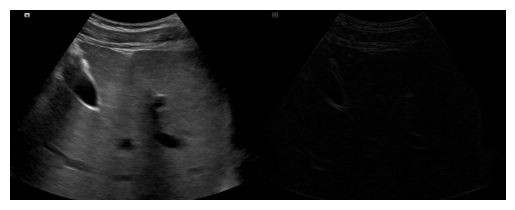

In [107]:
x_sobel: torch.Tensor = K.filters.sobel(x_rgb)
imshow(x_sobel)

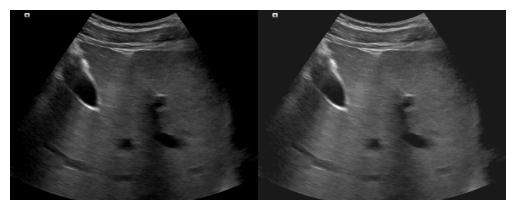

In [117]:
x_br = K.enhance.adjust_brightness(x_rgb, 0.1)
imshow(x_br)

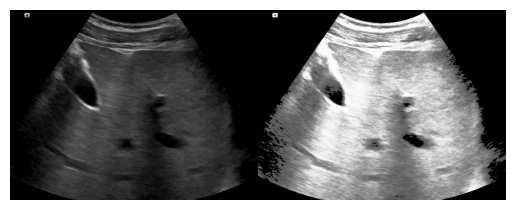

In [119]:
x_eq = K.enhance.equalize(x_br)
imshow(x_eq)

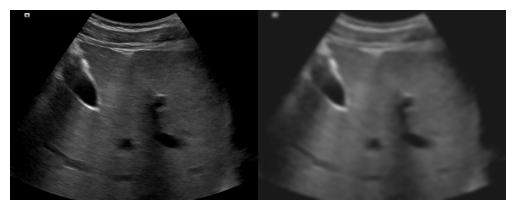

In [115]:
# Gaussian blur
x_blur_gs: torch.Tensor = K.filters.gaussian_blur2d(x_br, (41, 41), (5.0, 5.0))
imshow(x_blur_gs)

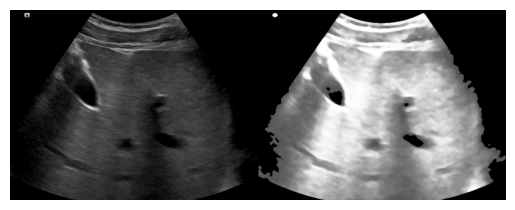

In [102]:
x_blur: torch.Tensor = K.filters.median_blur(x_eq, (11, 11))
imshow(x_blur)

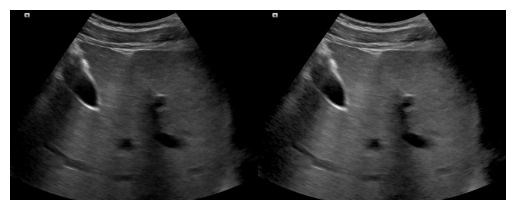

In [147]:
x_out: torch.Tensor = K.enhance.adjust_gamma(x_rgb, 0.8)
imshow(x_out)

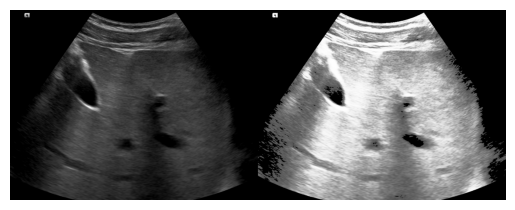

In [148]:
x_eq = K.enhance.equalize(x_out)
imshow(x_eq)

## NORMALIZATION

In [85]:
# example - https://gist.github.com/Huud/8e0823fa7be2dcd1bb9f3c418cb94c19
# calculate th emean and std of a dataset

mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(images)

for im_name in images:
    im_file = os.path.join(IMAGE_FOLDER, im_name)
    im = Image.open(im_file).convert('RGB')
    im = np.array(im) / 255.
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

for im_name in images:
    im_file = os.path.join(IMAGE_FOLDER, im_name)
    im = Image.open(im_file).convert('RGB')
    im = np.array(im) / 255.
    for j in range(3):
        stdTemp[j] += ((im[:,:,j] - mean[j])**2).sum()/(im.shape[0]*im.shape[1])

std = np.sqrt(stdTemp/numSamples)

print(mean)
print(std)

[0.0969821 0.0969821 0.0969821]
[0.12610687 0.12610687 0.12610687]


In [34]:
type(x_rgb)

torch.Tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


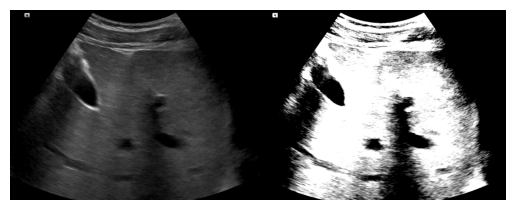

In [106]:
x_norm = K.enhance.normalize(x_rgb, torch.tensor(mean), torch.tensor(std))
imshow(x_norm)
# x_norm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


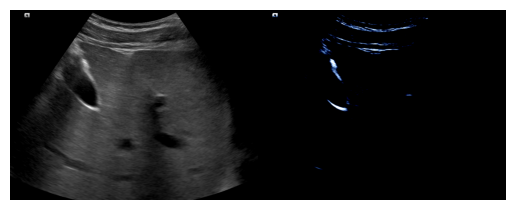

In [92]:
imageNet_mean = [0.485, 0.456, 0.406]
imageNet_std = [0.229, 0.224, 0.225]
x_norm_imageNet = K.enhance.normalize(x_rgb, torch.tensor(imageNet_mean), torch.tensor(imageNet_std))
imshow(x_norm_imageNet)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


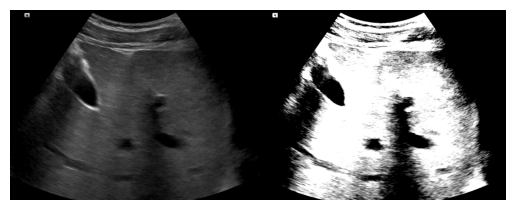

In [89]:
norm = transforms.Normalize(mean, std)
x_norm3 = norm(x_rgb)
imshow(x_norm3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


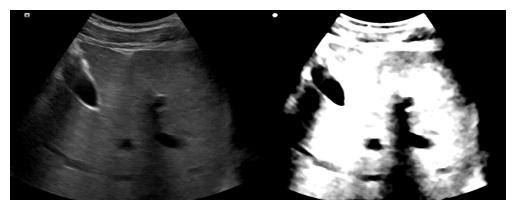

In [94]:
x_blur: torch.Tensor = K.filters.median_blur(x_norm, (11, 11))
imshow(x_blur)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


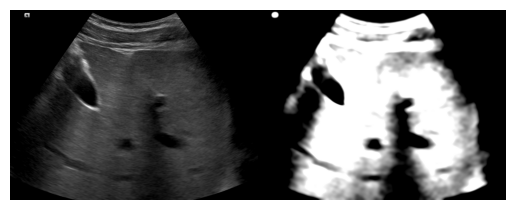

In [95]:
# Gaussian blur
x_blur_gs: torch.Tensor = K.filters.gaussian_blur2d(x_norm, (21, 21), (5.0, 5.0))
imshow(x_blur_gs)

## Preprocess all data

In [150]:
IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/liver2_mini/images"
PROCESSED_IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/liver2_mini/preprocessed/normalized"

if not os.path.exists(PROCESSED_IMAGE_FOLDER):
    os.makedirs(PROCESSED_IMAGE_FOLDER)

images = sorted(os.listdir(IMAGE_FOLDER))

# STEP 1 - find mean and std
mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(images)

for im_name in images:
    im_file = os.path.join(IMAGE_FOLDER, im_name)
    im = Image.open(im_file).convert('RGB')
    im = np.array(im) / 255.
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

for im_name in images:
    im_file = os.path.join(IMAGE_FOLDER, im_name)
    im = Image.open(im_file).convert('RGB')
    im = np.array(im) / 255.
    for j in range(3):
        stdTemp[j] += ((im[:,:,j] - mean[j])**2).sum()/(im.shape[0]*im.shape[1])

std = np.sqrt(stdTemp/numSamples)

print(mean)
print(std)

[0.0969821 0.0969821 0.0969821]
[0.12610687 0.12610687 0.12610687]


In [185]:
# STEP 2 - normalize and save data
for im_name in images[:1]:
    im_file = os.path.join(IMAGE_FOLDER, im_name)
    im_pil = Image.open(im_file).convert('RGB')
    print(type(im_pil), im_pil.size)
    x_rgb: torch.Tensor = K.io.load_image(im_file, K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
    # x_gray = K.color.rgb_to_grayscale(x_rgb)

    # process
    x_norm = K.enhance.normalize(x_rgb, torch.tensor(mean), torch.tensor(std))
    print(type(x_norm), x_norm.shape)
    x_numpy = K.utils.image.tensor_to_image(x_norm)
    print(type(x_numpy), x_numpy.shape)
    processed_image = Image.fromarray(x_numpy * 255.).convert("255")
    print(type(processed_image ), processed_image.size)

    # save
    new_im_file = os.path.join(PROCESSED_IMAGE_FOLDER, im_name)
    processed_image.save(str(new_im_file))

<class 'PIL.Image.Image'> (844, 648)
<class 'torch.Tensor'> torch.Size([1, 3, 648, 844])
<class 'numpy.ndarray'> (648, 844, 3)


TypeError: Cannot handle this data type: (1, 1, 3), <f4

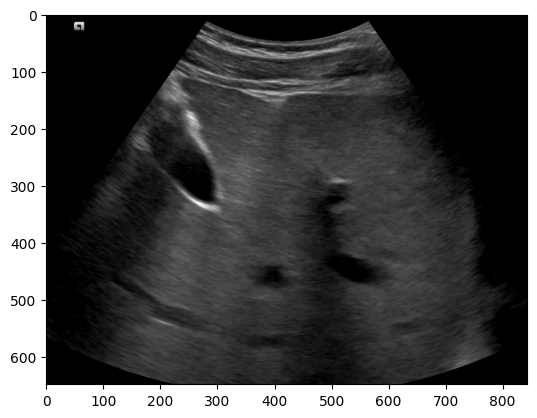

In [181]:
plt.imshow(im_pil)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-0.7690469  -0.7379497  -0.70685256 -0.6757553  -0.64465815 -0.613561
 -0.5824638  -0.5513666  -0.5202694  -0.48917222 -0.45807505 -0.42697787
 -0.39588067 -0.3647835  -0.33368632 -0.30258915 -0.27149191 -0.24039474
 -0.20929755 -0.17820038 -0.14710319 -0.11600601 -0.08490883 -0.05381165
 -0.02271447  0.00838272  0.0394799   0.07057708  0.10167427  0.13277145
  0.16386862  0.19496581  0.22606304  0.25716025  0.28825742  0.3193546
  0.35045177  0.38154897  0.41264614  0.44374332  0.4748405   0.5059377
  0.53703487  0.56813204  0.5992292   0.6303264   0.6614236   0.6925208
  0.723618    0.75471514  0.7858123   0.8169095   0.84800667  0.8791039
  0.9102011   0.94129825  0.9723954   1.0034926   1.0345898   1.065687
  1.0967841   1.1278813   1.1589785   1.1900756   1.221173    1.2522702
  1.2833674   1.3144646   1.3455617   1.3766589   1.4077561   1.4388534
  1.4699506   1.5010477   1.5321449   1.5632421   1.5943393   1.6254364
  1.6565336   1.6876308   1.718728    1.7498251   1.7809223   

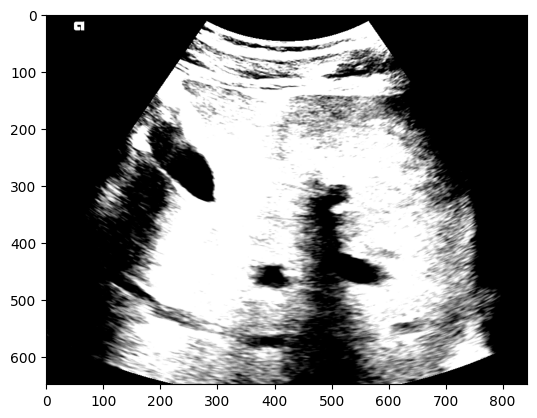

In [178]:
plt.imshow(x_numpy)
print(np.unique(x_numpy))

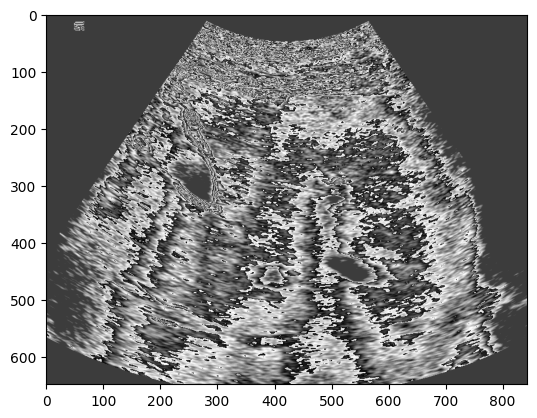

In [179]:
plt.imshow(processed_image)

In [1]:
plt.imshow(x_numpy)

NameError: name 'plt' is not defined

## CAROTID_MIXED

In [3]:
IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/CAROTID_MIXED/val_mini/images"

images = sorted(os.listdir(IMAGE_FOLDER))

# STEP 1 - find mean and std
mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])

numSamples = len(images)

for im_name in images:
    im_file = os.path.join(IMAGE_FOLDER, im_name)
    im = Image.open(im_file).convert('RGB')
    im = np.array(im) / 255.
    
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])

mean = (mean/numSamples)

for im_name in images:
    im_file = os.path.join(IMAGE_FOLDER, im_name)
    im = Image.open(im_file).convert('RGB')
    im = np.array(im) / 255.
    for j in range(3):
        stdTemp[j] += ((im[:,:,j] - mean[j])**2).sum()/(im.shape[0]*im.shape[1])

std = np.sqrt(stdTemp/numSamples)

print(mean)
print(std)

[0.11344986 0.11344986 0.11344986]
[0.14795753 0.14795753 0.14795753]


In [4]:
%%capture
!pip install kornia
!pip install kornia-rs

import kornia as K
import torch
import torchvision
from matplotlib import pyplot as plt

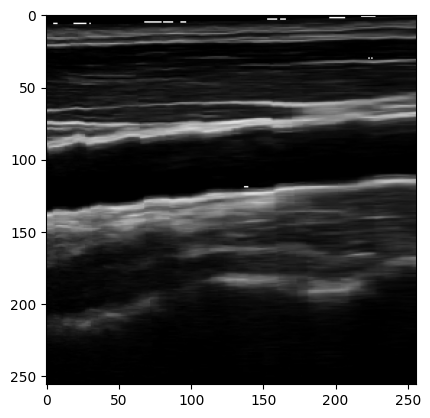

In [5]:
im0=images[0]
im_file = os.path.join(IMAGE_FOLDER, im0)
im = Image.open(im_file).convert('RGB')
plt.imshow(im)

In [6]:
# ref: https://kornia.github.io/tutorials/nbs/filtering_operators.html
x_rgb: torch.Tensor = K.io.load_image(im_file, K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
x_gray = K.color.rgb_to_grayscale(x_rgb)

In [7]:
def imshow(input: torch.Tensor):
    if input.shape != x_rgb.shape:
        input = K.geometry.resize(input, size=(x_rgb.shape[-2:]))
    out = torch.cat([x_rgb, input], dim=-1)
    out = torchvision.utils.make_grid(out, nrow=2, padding=5)
    out_np = K.utils.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis("off")
    plt.show()

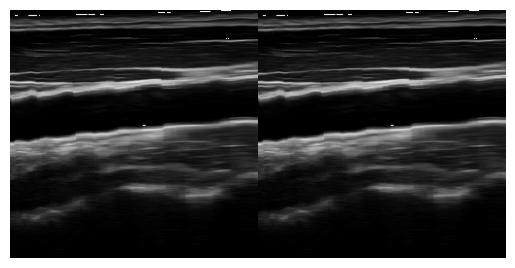

In [8]:
imshow(x_rgb)

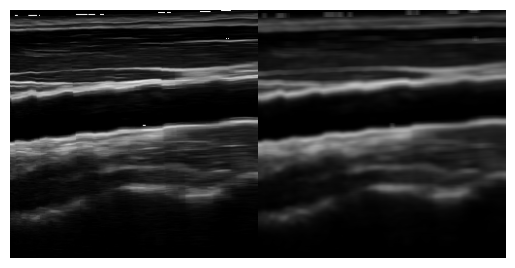

In [36]:
# Gaussian blur
x_gaus: torch.Tensor = K.filters.gaussian_blur2d(x_rgb, (5, 5), (5.0, 5.0))
imshow(x_gaus)

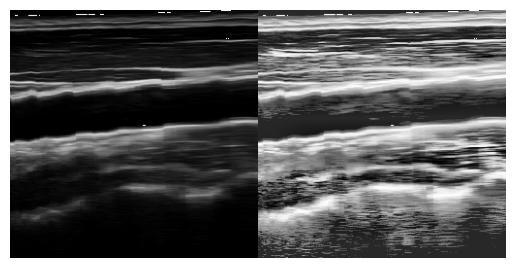

In [47]:
# x_eq = K.enhance.equalize(x_rgb)
x_eq = K.enhance.equalize_clahe(x_rgb)
imshow(x_eq)

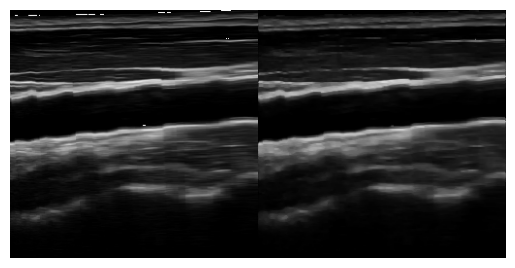

In [38]:
x_med: torch.Tensor = K.filters.median_blur(x_rgb, (3, 3))
imshow(x_med)

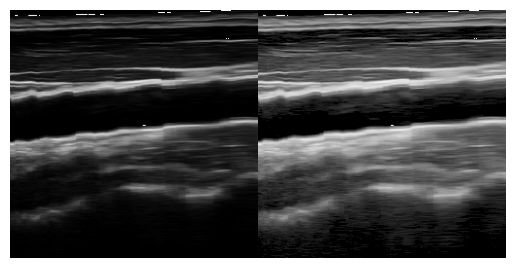

In [34]:
x_enh: torch.Tensor = K.enhance.adjust_gamma(x_rgb, 0.5)
imshow(x_enh)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


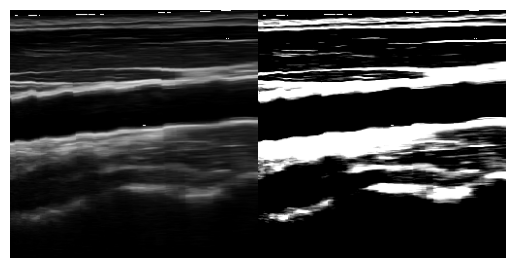

In [48]:
x_norm = K.enhance.normalize(x_rgb, torch.tensor(mean), torch.tensor(std))
imshow(x_norm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


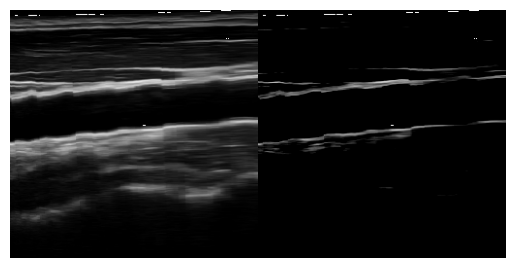

In [90]:
x_norm2 = K.enhance.normalize_min_max(x_rgb, min_val=-1.0, max_val=1.0)
imshow(x_norm2)

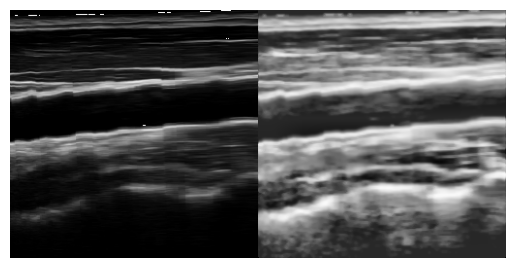

In [126]:
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from typing import Any, Callable, Iterable, Optional, Tuple, Union
import cv2
from torchvision import transforms


In [127]:
class ImagesDataset(Dataset):
    """A very simple dataset for loading images."""

    def __init__(self, filenames: str, images_root: Optional[str] = None, transform: Optional[Callable] = None,
                 prepare_filenames: bool = True) -> None:
        self.root = None if images_root is None else Path(images_root)
        self.filenames = sorted(list(set(filenames))) if prepare_filenames else filenames
        self.transform = transform

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path = self.filenames[index]
        full_path = Path(path) if self.root is None else self.root / path
        assert full_path.is_file(), f'Not a file: {full_path}'
        image = Image.open(im_file).convert('RGB')
        # image =  
        # image = cv2.imread(str(full_path))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image)
        return image, path, index

    def __len__(self) -> int:
        return len(self.filenames)

In [144]:
class OnlineMeanStd:
    # ref: https://github.com/Nikronic/CoarseNet/blob/master/utils/preprocess.py#L142-L200
    def __init__(self):
        pass

    def __call__(self, dataset, batch_size, method='strong'):
        """
        Calculate mean and std of a dataset in lazy mode (online)
        On mode strong, batch size will be discarded because we use batch_size=1 to minimize leaps.

        :param dataset: Dataset object corresponding to your dataset
        :param batch_size: higher size, more accurate approximation
        :param method: weak: fast but less accurate, strong: slow but very accurate - recommended = strong
        :return: A tuple of (mean, std) with size of (3,)
        """

        if method == 'weak':
            loader = DataLoader(dataset=dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0,
                                pin_memory=0)
            mean = 0.
            std = 0.
            nb_samples = 0.
            for item in loader:
                images, files, indices = item
                # print("item=", item)
                # data = data['y_descreen']
                data = images
                batch_samples = data.size(0)
                data = data.view(batch_samples, data.size(1), -1)
                mean += data.mean(2).sum(0)
                std += data.std(2).sum(0)
                nb_samples += batch_samples

            mean /= nb_samples
            std /= nb_samples

            return mean, std

        elif method == 'strong':
            loader = DataLoader(dataset=dataset,
                                batch_size=1,
                                shuffle=False,
                                num_workers=0,
                                pin_memory=0)
            cnt = 0
            fst_moment = torch.empty(3)
            snd_moment = torch.empty(3)

            for item in loader:
                # data = data['y_descreen']
                images, files, indices = item
                data = images
                b, c, h, w = data.shape
                nb_pixels = b * h * w
                sum_ = torch.sum(data, dim=[0, 2, 3])
                sum_of_square = torch.sum(data ** 2, dim=[0, 2, 3])
                fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
                snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

                cnt += nb_pixels

            return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

In [145]:
images_list = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/CAROTID_MIXED/val_mini/lists/images.txt"
images_root = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/CAROTID_MIXED/val_mini/images"
filenames = Path(images_list).read_text().splitlines()
transform = transforms.Compose([transforms.ToTensor()])
dataset = ImagesDataset(filenames=filenames, images_root=images_root, transform=transform)

In [152]:
item = dataset[0]
# item

In [299]:
meanStdCalculator = OnlineMeanStd()
mean, std = meanStdCalculator(dataset, batch_size=10, method='weak')
mean2, std2 = meanStdCalculator(dataset, batch_size=1, method='strong')

print(f'weak method: mean={mean}, std={std}')
print(f'strong method: mean={mean2}, std={std2}')

weak method: mean=tensor([0.0838, 0.0838, 0.0838]), std=tensor([0.1461, 0.1461, 0.1461])
strong method: mean=tensor([0.0838, 0.0838, 0.0838]), std=tensor([0.1461, 0.1461, 0.1461])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


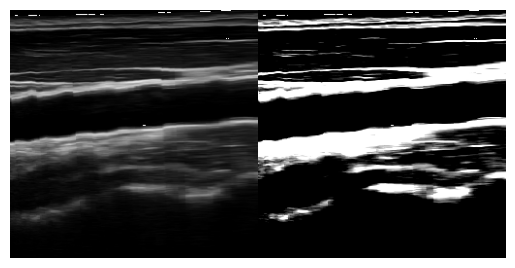

In [151]:
x_norm = K.enhance.normalize(x_rgb, mean2,std2)
imshow(x_norm)

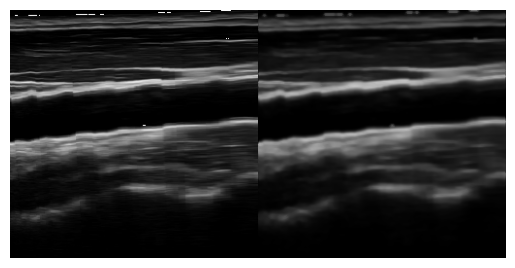

In [163]:
# combine preprocessing steps:
# 1 - adaptive equalization
# 2 - median filter
# 3 - gaussian filter
# 4 - normalize

x: torch.Tensor = K.io.load_image(im_file, K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
# x = K.color.rgb_to_grayscale(x)
# x = K.enhance.equalize_clahe(x)
x = K.filters.gaussian_blur2d(x, (11,11), (1.0,1.0))
x = K.filters.median_blur(x, (3,3))
# x = K.enhance.equalize_clahe(x)
# x = K.enhance.normalize(x, torch.tensor(mean), torch.tensor(std))
imshow(x)


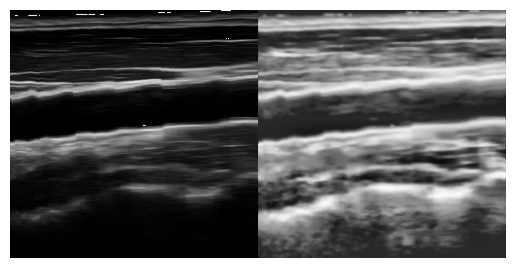

In [157]:
# combine preprocessing steps:
# 1 - adaptive equalization
# 2 - median filter
# 3 - gaussian filter
# 4 - normalize

x: torch.Tensor = K.io.load_image(im_file, K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
# x = K.color.rgb_to_grayscale(x)
x = K.enhance.equalize_clahe(x)
x = K.filters.gaussian_blur2d(x, (5,5), (1.0,1.0))
x = K.filters.median_blur(x, (3,3))
# x = K.enhance.equalize_clahe(x)
# x = K.enhance.normalize(x, torch.tensor(mean), torch.tensor(std))
imshow(x)


In [254]:
# make equalize_clahe into a module
from torch.nn import Module, Parameter
from torch import Tensor
from kornia.enhance import equalize_clahe

class EqualizeClahe(Module):
    def __init__(self, 
                clip_limit: float = 40.0,
                grid_size: Tuple[int, int] = (8, 8),
                slow_and_differentiable: bool = False
                 ) -> None:
        super().__init__()
        self.clip_limit = clip_limit
        self.grid_size = grid_size
        self.slow_and_differentiable = slow_and_differentiable

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}"
            f"(clip_limit={self.clip_limit}, "
            f"grid_size={self.grid_size}, "
            f"slow_and_differentiable={self.slow_and_differentiable})"
        )

    def forward(self, input: Tensor) -> Tensor:
        # ref: https://kornia.readthedocs.io/en/latest/_modules/kornia/enhance/equalization.html#equalize_clahe
        return equalize_clahe(input, self.clip_limit, self.grid_size, self.slow_and_differentiable)

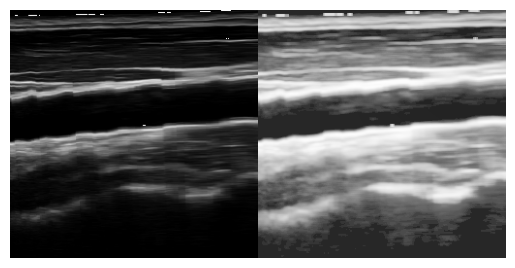

In [285]:
preprocessing_pipeline = K.augmentation.container.ImageSequential(
    K.filters.GaussianBlur2d((3,3), (5.,5.)),
    EqualizeClahe(grid_size = (2,2)),
    # K.filters.MedianBlur((3,3)),
)
x = preprocessing_pipeline(x_rgb)
imshow(x)

In [286]:
PROCESSED_IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/CAROTID_MIXED/val_mini/preprocessed"

if not os.path.exists(PROCESSED_IMAGE_FOLDER):
    os.makedirs(PROCESSED_IMAGE_FOLDER)


In [293]:
# STEP 2 - preprocess and save data
for im_name in images:
    # read file
    im_file = os.path.join(IMAGE_FOLDER, im_name)
    x_rgb: torch.Tensor = K.io.load_image(im_file, K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
    
    # process
    x = preprocessing_pipeline(x_rgb)
    x_numpy = K.utils.image.tensor_to_image(x)
    processed_image = Image.fromarray(np.uint8(x_numpy* 255))

    # save
    new_im_file = os.path.join(PROCESSED_IMAGE_FOLDER, im_name)
    
    processed_image.save(str(new_im_file))

## CAROTID_MUTINFO

In [294]:
IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/CAROTID_MUTINFO/val_mini/images"
PROCESSED_IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/CAROTID_MUTINFO/val_mini/preprocessed"

if not os.path.exists(PROCESSED_IMAGE_FOLDER):
    os.makedirs(PROCESSED_IMAGE_FOLDER)

images = sorted(os.listdir(IMAGE_FOLDER))

preprocessing_pipeline = K.augmentation.container.ImageSequential(
    K.filters.GaussianBlur2d((3,3), (5.,5.)),
    EqualizeClahe(grid_size = (2,2)),
    # K.filters.MedianBlur((3,3)),
)

for im_name in images:
    # read file
    im_file = os.path.join(IMAGE_FOLDER, im_name)
    x_rgb: torch.Tensor = K.io.load_image(im_file, K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
    
    # process
    x = preprocessing_pipeline(x_rgb)
    x_numpy = K.utils.image.tensor_to_image(x)
    processed_image = Image.fromarray(np.uint8(x_numpy* 255))

    # save
    new_im_file = os.path.join(PROCESSED_IMAGE_FOLDER, im_name)
    
    processed_image.save(str(new_im_file))


## LIVER_MIXED

In [295]:
IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/LIVER_MIXED/val_mini/images"
PROCESSED_IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/LIVER_MIXED/val_mini/preprocessed"

if not os.path.exists(PROCESSED_IMAGE_FOLDER):
    os.makedirs(PROCESSED_IMAGE_FOLDER)

images = sorted(os.listdir(IMAGE_FOLDER))

preprocessing_pipeline = K.augmentation.container.ImageSequential(
    K.filters.GaussianBlur2d((3,3), (5.,5.)),
    EqualizeClahe(grid_size = (2,2)),
    # K.filters.MedianBlur((3,3)),
)

for im_name in images:
    # read file
    im_file = os.path.join(IMAGE_FOLDER, im_name)
    x_rgb: torch.Tensor = K.io.load_image(im_file, K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
    
    # process
    x = preprocessing_pipeline(x_rgb)
    x_numpy = K.utils.image.tensor_to_image(x)
    processed_image = Image.fromarray(np.uint8(x_numpy* 255))

    # save
    new_im_file = os.path.join(PROCESSED_IMAGE_FOLDER, im_name)
    
    processed_image.save(str(new_im_file))


## THYROID COMPOUNDED

In [298]:
IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/THYROID_COMPOUNDED/val_mini/images"
PROCESSED_IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/THYROID_COMPOUNDED/val_mini/preprocessed3"

if not os.path.exists(PROCESSED_IMAGE_FOLDER):
    os.makedirs(PROCESSED_IMAGE_FOLDER)

images = sorted(os.listdir(IMAGE_FOLDER))

preprocessing_pipeline = K.augmentation.container.ImageSequential(
    K.filters.GaussianBlur2d((3,3), (5.,5.)),
    EqualizeClahe(grid_size = (2,2)),
    # K.filters.MedianBlur((5,5)),
)

for im_name in images:
    # read file
    im_file = os.path.join(IMAGE_FOLDER, im_name)
    x_rgb: torch.Tensor = K.io.load_image(im_file, K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
    
    # process
    x = preprocessing_pipeline(x_rgb)
    x_numpy = K.utils.image.tensor_to_image(x)
    processed_image = Image.fromarray(np.uint8(x_numpy* 255))

    # save
    new_im_file = os.path.join(PROCESSED_IMAGE_FOLDER, im_name)
    
    processed_image.save(str(new_im_file))


## Wrapping up in a function

In [300]:
import os
from tqdm import tqdm
import numpy as np
from PIL import Image

import kornia as K
import torch

# make equalize_clahe into a module
from torch.nn import Module
from torch import Tensor
from kornia.enhance import equalize_clahe

class EqualizeClahe(Module):
    def __init__(self, 
                clip_limit: float = 40.0,
                grid_size: Tuple[int, int] = (8, 8),
                slow_and_differentiable: bool = False
                 ) -> None:
        super().__init__()
        self.clip_limit = clip_limit
        self.grid_size = grid_size
        self.slow_and_differentiable = slow_and_differentiable

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}"
            f"(clip_limit={self.clip_limit}, "
            f"grid_size={self.grid_size}, "
            f"slow_and_differentiable={self.slow_and_differentiable})"
        )

    def forward(self, input: Tensor) -> Tensor:
        # ref: https://kornia.readthedocs.io/en/latest/_modules/kornia/enhance/equalization.html#equalize_clahe
        return equalize_clahe(input, self.clip_limit, self.grid_size, self.slow_and_differentiable)

def preprocess_dataset(image_folder, processed_image_folder, preprocessing_pipeline):
    # IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/THYROID_COMPOUNDED/val_mini/images"
    # PROCESSED_IMAGE_FOLDER = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/THYROID_COMPOUNDED/val_mini/preprocessed3"

    if not os.path.exists(processed_image_folder):
        os.makedirs(processed_image_folder)

    images = sorted(os.listdir(image_folder))

    for im_name in tqdm(images):
        # read file
        im_file = os.path.join(image_folder, im_name)
        x_rgb: torch.Tensor = K.io.load_image(im_file, K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
        
        # process
        x = preprocessing_pipeline(x_rgb)
        x_numpy = K.utils.image.tensor_to_image(x)
        processed_image = Image.fromarray(np.uint8(x_numpy* 255))

        # save
        new_im_file = os.path.join(processed_image_folder, im_name)
        
        processed_image.save(str(new_im_file))


In [ ]:
preprocessing_pipeline = K.augmentation.container.ImageSequential(
    K.filters.GaussianBlur2d((3,3), (5.,5.)),
    EqualizeClahe(grid_size = (2,2)),
    # K.filters.MedianBlur((5,5)),
)

